# Mortgage Approval Classifier

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

## Loading Data

In [23]:
chunks = []
chunk_size = 500000  
# we can chunk the dataset so that we don't have to load the entire 4.6 GB dataset w pandas (bc this takes a long time)
# use 500k rows per chunk

for i, chunk in enumerate(pd.read_csv(
    "/Users/amandacao/Downloads/2024_public_lar_csv.csv",
    chunksize=chunk_size,
    low_memory=False
)):
    # filter for NY during chunking process
    ny_chunk = chunk[chunk['state_code'] == 'NY']
    if len(ny_chunk) > 0:
        chunks.append(ny_chunk)
    print(f"  Processed chunk {i+1}: {len(ny_chunk):,} NY records found")

# concatenate the chunks together
hmda_data = pd.concat(chunks, ignore_index=True)
print(f"\nTotal NY records loaded: {len(hmda_data):,}")
print(f"Number of columns: {len(hmda_data.columns)}")

  Processed chunk 1: 17,908 NY records found
  Processed chunk 2: 23,601 NY records found
  Processed chunk 3: 18,258 NY records found
  Processed chunk 4: 16,559 NY records found
  Processed chunk 5: 9,760 NY records found
  Processed chunk 6: 10,742 NY records found
  Processed chunk 7: 9,460 NY records found
  Processed chunk 8: 12,133 NY records found
  Processed chunk 9: 17,538 NY records found
  Processed chunk 10: 15,026 NY records found
  Processed chunk 11: 14,815 NY records found
  Processed chunk 12: 24,752 NY records found
  Processed chunk 13: 18,411 NY records found
  Processed chunk 14: 21,564 NY records found
  Processed chunk 15: 7,666 NY records found
  Processed chunk 16: 12,959 NY records found
  Processed chunk 17: 12,010 NY records found
  Processed chunk 18: 14,974 NY records found
  Processed chunk 19: 22,547 NY records found
  Processed chunk 20: 18,576 NY records found
  Processed chunk 21: 14,450 NY records found
  Processed chunk 22: 9,428 NY records found
 

In [33]:
print(hmda_data.columns.tolist())

['activity_year', 'lei', 'derived_msa_md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'construction_method', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'multifamily_affordable_units', 'income', 'debt_to_income_ratio', 'applicant_cre

In [61]:
hmda_data['loan_type'].unique()

array([1, 3, 2, 4])

In [35]:
hmda_data.head(10)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2024,WWB2V0FCW3A0EE3ZJN75,99999,NY,36105.0,36105950500.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3075,31.93,83800,99.0,752,1506,54
1,2024,WWB2V0FCW3A0EE3ZJN75,40380,NY,36073.0,36073401300.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4564,11.61,98700,99.0,1672,2246,60
2,2024,WWB2V0FCW3A0EE3ZJN75,13780,NY,36007.0,36007000700.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3501,21.31,88700,58.0,966,1398,79
3,2024,WWB2V0FCW3A0EE3ZJN75,40380,NY,36055.0,36055013901.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3912,25.64,98700,74.0,1257,1462,65
4,2024,WWB2V0FCW3A0EE3ZJN75,40380,NY,36055.0,36055014906.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3917,11.16,98700,93.0,1049,1241,40
5,2024,WWB2V0FCW3A0EE3ZJN75,15380,NY,36029.0,36029014804.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3995,6.18,96900,103.0,1390,1738,42
6,2024,WWB2V0FCW3A0EE3ZJN75,35614,NY,36087.0,36087012204.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3926,11.84,101900,55.0,313,638,51
7,2024,WWB2V0FCW3A0EE3ZJN75,35614,NY,36119.0,36119008302.0,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7101,19.31,101900,243.0,2126,2487,48
8,2024,WWB2V0FCW3A0EE3ZJN75,35614,NY,36087.0,36087010501.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5291,46.23,101900,162.0,1302,1425,46
9,2024,WWB2V0FCW3A0EE3ZJN75,28880,NY,36071.0,36071001100.0,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,4775,76.94,114800,66.0,665,1542,70


## Filtering Data

Filtering criteria:
- Filter for NY state only
- Keep action_taken = 1 (loan originated) and action_taken = 3 (application denied)
- Focus on conventional loans (loan_type = 1)
- Within conventional loans, filter for conforming loans (conforming_loan_limit = C)
- Drop sensitive protected class information (race, ethnicity, sex)

In [222]:
# check to make sure NY filtering worked
print(hmda_data['state_code'].unique())
print(f"Total records: {len(hmda_data):,}")

['NY']
Total records: 383,577


In [224]:
# filter for approved and denied actions
hmda_filtered = hmda_data[hmda_data['action_taken'].isin([1, 3])]
print(f"Records after filtering action: {len(hmda_filtered):,}")

Records after filtering action: 283,332


In [226]:
# filter for conventional loans only (loan_type = 1)
hmda_filtered = hmda_filtered[hmda_filtered['loan_type'] == 1]
print(f"Records after conventional loan filter: {len(hmda_filtered):,}")

print(hmda_filtered['loan_type'].unique())

Records after conventional loan filter: 256,584
[1]


In [228]:
# filter for conforming loans only
hmda_filtered = hmda_filtered[hmda_filtered['conforming_loan_limit'] == 'C']
print(f"Records after conforming loan filter: {len(hmda_filtered):,}")

print(hmda_filtered['conforming_loan_limit'].unique())

Records after conforming loan filter: 244,536
['C']


In [230]:
# Drop the following columns:
# 1. identifier columns (such as applicant number, year, state code, etc)
# 2. protected class information (race, ethnicity, sex)
# 3. non-predictive columns
# 4. repetitive columns (conforming loan limit + conventional loans, bc there's only one value for these after filter)

drop = [
    # identifiers
    'lei', 'activity_year', 'derived_msa_md', 'state_code', 'county_code', 'census_tract',
    
    # protected class information (race, ethnicity, sex, age)
    'derived_ethnicity', 'derived_race', 'derived_sex',
    'applicant_ethnicity_1', 'applicant_ethnicity_2', 'applicant_ethnicity_3', 'applicant_ethnicity_4', 'applicant_ethnicity_5',
    'co_applicant_ethnicity_1', 'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3', 'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5',
    'applicant_ethnicity_observed', 'co_applicant_ethnicity_observed',
    'applicant_race_1', 'applicant_race_2', 'applicant_race_3', 'applicant_race_4', 'applicant_race_5',
    'co_applicant_race_1', 'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5',
    'applicant_race_observed', 'co_applicant_race_observed',
    'applicant_sex', 'co_applicant_sex', 'applicant_sex_observed', 'co_applicant_sex_observed',
    'applicant_age', 'co_applicant_age', 'applicant_age_above_62', 'co_applicant_age_above_62',
    
    # denial reasons (leakage because this is information that is populated after the decision)
    'denial_reason_1', 'denial_reason_2', 'denial_reason_3', 'denial_reason_4',

    # other leakage reasons (variables that are only known / decided after the loan status)
    'purchaser_type', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'loan_term', 
    'interest_rate', 'combined_loan_to_value_ratio', 'property_value',
    
    # non-predictive columns
    'derived_loan_product_type', 'derived_dwelling_category',
    'applicant_credit_score_type', 'co_applicant_credit_score_type',
    'initially_payable_to_institution', 'aus_1', 'aus_2', 'aus_3', 'aus_4', 'aus_5',
    'aus_result_1', 'aus_result_2', 'aus_result_3', 'aus_result_4', 'aus_result_5',
    'submission_of_application', 'reverse_mortgage', 'open_end_line_of_credit',
    'intro_rate_period', 'balloon_payment', 'interest_only_payment', 'negative_amortization',
    'other_nonamortizing_features', 'manufactured_home_secured_property_type',
    'manufactured_home_land_property_interest', 'multifamily_affordable_units',
    'total_points_and_fees', 'prepayment_penalty_term', 'origination_charges',
    'discount_points', 'lender_credits', 

    # redundnat cols
    'conforming_loan_limit', 'loan_type'
]


# Only drop columns that exist in the dataframe
cols_to_drop_existing = [col for col in drop if col in hmda_filtered.columns]
hmda_final = hmda_filtered.drop(columns=cols_to_drop_existing)

print(f"Columns dropped: {len(cols_to_drop_existing)}")
print(f"Remaining columns: {len(hmda_final.columns)}")

Columns dropped: 81
Remaining columns: 18


In [232]:
# View remaining columns
print("Remaining columns:")
print(hmda_final.columns.tolist())

Remaining columns:
['action_taken', 'preapproval', 'loan_purpose', 'lien_status', 'business_or_commercial_purpose', 'loan_amount', 'construction_method', 'occupancy_type', 'total_units', 'income', 'debt_to_income_ratio', 'tract_population', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units']


## Exploratory Data Analysis

In [234]:
# missing values
print(hmda_final.isnull().sum())

action_taken                             0
preapproval                              0
loan_purpose                             0
lien_status                              0
business_or_commercial_purpose           0
loan_amount                              0
construction_method                      0
occupancy_type                           0
total_units                              0
income                               14763
debt_to_income_ratio                 16290
tract_population                         0
tract_minority_population_percent        0
ffiec_msa_md_median_family_income        0
tract_to_msa_income_percentage           0
tract_owner_occupied_units               0
tract_one_to_four_family_homes           0
tract_median_age_of_housing_units        0
dtype: int64


In [236]:
# in our remaining columns, we see that the debt to income ratio column conatains "Exempt" values
print(hmda_final['debt_to_income_ratio'].value_counts())

debt_to_income_ratio
20%-<30%    32216
30%-<36%    31208
>60%        25323
50%-60%     16822
<20%        13346
49          10682
42           8459
44           8441
Exempt       7642
41           7495
43           7419
48           7125
40           7114
39           7040
38           6598
47           6532
45           6419
37           6267
46           6195
36           5903
Name: count, dtype: int64


In [238]:
# note that Exempt values consist of <5% of the data, so we can probably drop it for cleaner analysis
# also we want DTI ratio to be numeric, so we can find the midpoints of the ranges 

hmda_final = hmda_final[hmda_final['debt_to_income_ratio'] != 'Exempt']
print(f"Records after dropping Exempt: {len(hmda_final):,}")

Records after dropping Exempt: 236,894


The 2024 HMDA data reports DTI as both exact values (36-50%) and ranges. I converted ranges to their midpoints for modeling while preserving exact values, treating DTI as the continuous variable it fundamentally represents.

In [240]:
def convert_dti_hybrid(value):
    if value == 'Exempt' or value == 'NA':
        return np.nan
    elif value == '<20%':
        return 15  
    elif value == '20%-<30%':
        return 25
    elif value == '30%-<36%':
        return 33
    elif value == '50%-60%':
        return 55
    elif value == '>60%':
        return 65
    else:
        return value

hmda_final['debt_to_income_ratio'] = hmda_final['debt_to_income_ratio'].apply(convert_dti_hybrid)

In [242]:
# check new values for DTI ratio

print(hmda_final['debt_to_income_ratio'].value_counts())

debt_to_income_ratio
25    32216
33    31208
65    25323
55    16822
15    13346
49    10682
42     8459
44     8441
41     7495
43     7419
48     7125
40     7114
39     7040
38     6598
47     6532
45     6419
37     6267
46     6195
36     5903
Name: count, dtype: int64


Once we've processed the DTI ratio column, we can then drop null values for DTI ratio and income.

In [244]:
# Drop rows with missing key values
# Focus on income, loan_amount, and the new important features (DTI, LTV)

dropped_cols = ['debt_to_income_ratio', 'income']
hmda_final = hmda_final.dropna(subset=dropped_cols)
print(f"Records after dropping missing DTI ratio/income: {len(hmda_final)}")

Records after dropping missing DTI ratio/income: 218515


Then, we can move on to understanding + visualizing the data!

In [246]:
# check to see if classes are balanced
print(f"Total records: {len(hmda_final)}")
print(f"Actions taken: {hmda_final['action_taken'].unique()}")
print(f"\nApproved (1): {(hmda_final['action_taken']==1).sum()}")
print(f"Denied (3): {(hmda_final['action_taken']==3).sum()}")
print(f"\nApproval rate: {(hmda_final['action_taken']==1).mean():.2%}")

Total records: 218515
Actions taken: [1 3]

Approved (1): 158939
Denied (3): 59576

Approval rate: 72.74%


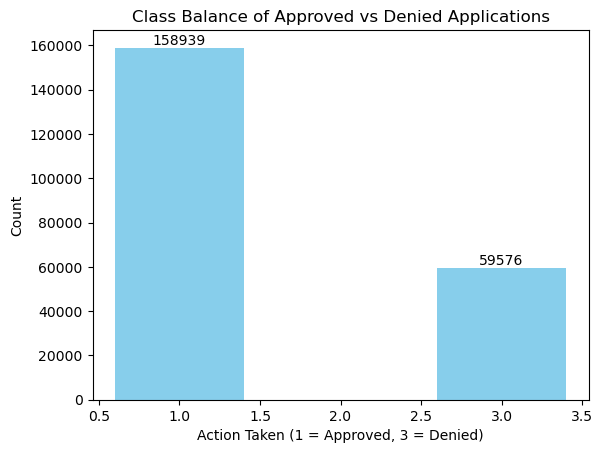

In [248]:
class_bal = hmda_final['action_taken'].value_counts()
fig, ax = plt.subplots()
bar_container = ax.bar(class_bal.index, class_bal.values, color='skyblue')
ax.bar_label(bar_container)
ax.set_xlabel('Action Taken (1 = Approved, 3 = Denied)')
ax.set_ylabel('Count')
ax.set_title('Class Balance of Approved vs Denied Applications')
plt.show()

In [250]:
print(f"Descriptive statistics for Loan Amount:")
print(hmda_final['loan_amount'].describe())

Descriptive statistics for Loan Amount:
count    2.185150e+05
mean     2.563699e+05
std      2.306183e+05
min      5.000000e+03
25%      8.500000e+04
50%      1.750000e+05
75%      3.650000e+05
max      2.215000e+06
Name: loan_amount, dtype: float64


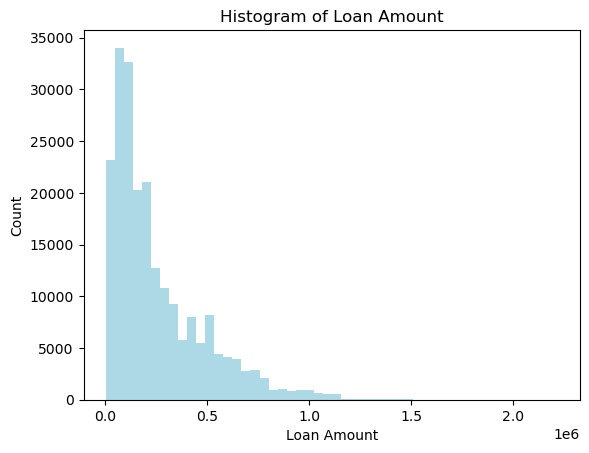

In [252]:
loan_amt = hmda_final['loan_amount']
plt.hist(loan_amt, bins=50, color='lightblue')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Histogram of Loan Amount')
plt.show()

We can repeat for other numerical predictors like income

In [254]:
print(f"Descriptive statistics for Applicant Income:")
print(hmda_final['income'].describe())

Descriptive statistics for Applicant Income:
count    218515.000000
mean        169.489747
std         790.026236
min       -2325.000000
25%          77.000000
50%         122.000000
75%         189.000000
max      250000.000000
Name: income, dtype: float64


In [258]:
# we see that the minimum income appears to be negative - this is probably an error? 
# we can remove all incomes less than 0 

min_inc = min(hmda_final['income'])
hmda_final = hmda_final[hmda_final['income'] > 0]

print(f"Descriptive statistics for Applicant Income:")
print(hmda_final['income'].describe())
print(f"Records after filtering for income: {len(hmda_final)}")

Descriptive statistics for Applicant Income:
count    217203.000000
mean        170.634457
std         792.215234
min           1.000000
25%          78.000000
50%         123.000000
75%         190.000000
max      250000.000000
Name: income, dtype: float64
Records after filtering for income: 217203


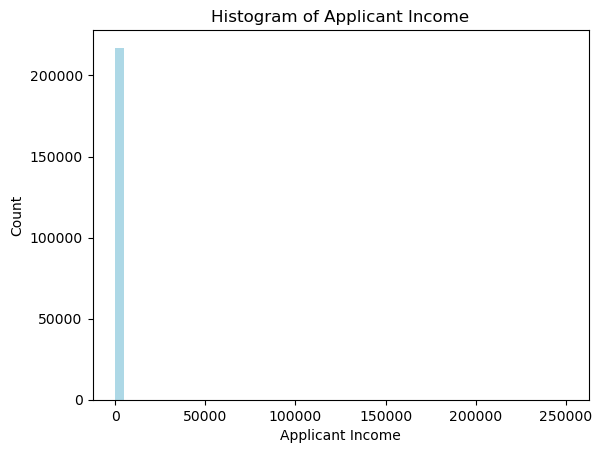

In [262]:
applicant_income = hmda_final['income']
plt.hist(applicant_income, bins=50, color='lightblue')
plt.xlabel('Applicant Income')
plt.ylabel('Count')
plt.title('Histogram of Applicant Income')
plt.show()

In [264]:
# filter to 99th percentile
upper_limit = hmda_final['income'].quantile(0.99)
print(f"99th percentile of income: ${upper_limit:,.0f}k")

hmda_final = hmda_final[hmda_final['income'] <= upper_limit]
print(f"Total records after filtering: {len(hmda_final)}")

99th percentile of income: $846k
Total records after filtering: 215030


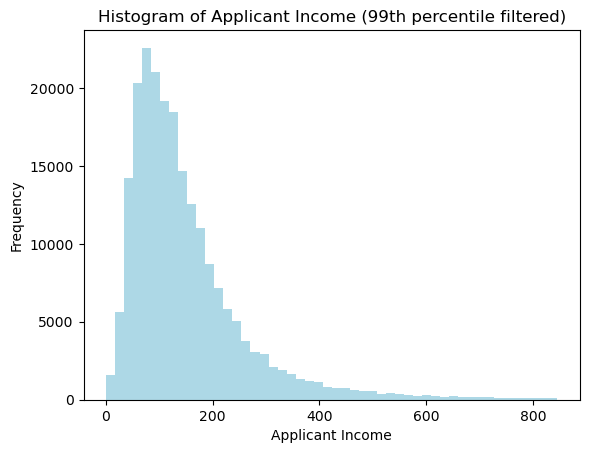

In [290]:
applicant_income = hmda_final['income']
plt.hist(applicant_income, bins=50, color='lightblue')
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.title('Histogram of Applicant Income (99th percentile filtered)')
plt.show()

Let's also visualize some of the census data!

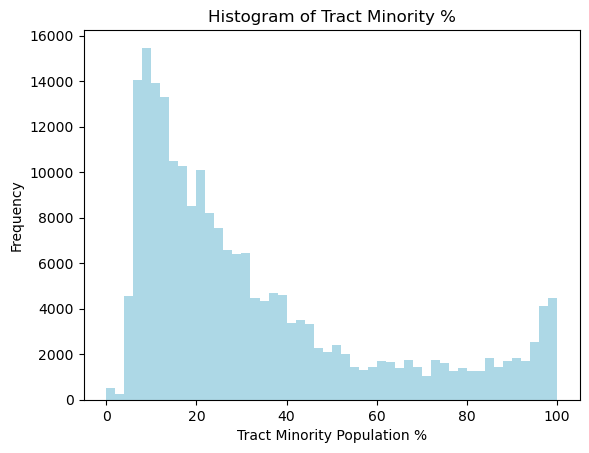

In [296]:
# census tract minority population - this could help us understand potentially discriminatory practices
minority_pct = hmda_final['tract_minority_population_percent']
plt.hist(minority_pct, bins=50, color='lightblue')
plt.xlabel('Tract Minority Population %')
plt.ylabel('Frequency')
plt.title('Histogram of Tract Minority %')
plt.show()

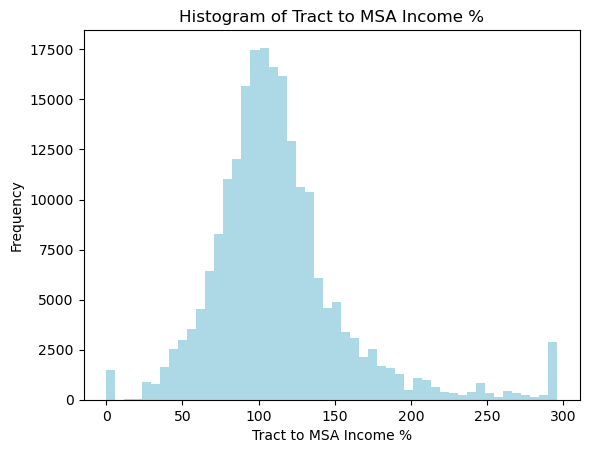

In [298]:
med_family_income = hmda_final['tract_to_msa_income_percentage']
plt.hist(med_family_income, bins=50, color='lightblue')
plt.xlabel('Tract to MSA Income %')
plt.ylabel('Frequency')
plt.title('Histogram of Tract to MSA Income %')
plt.show()


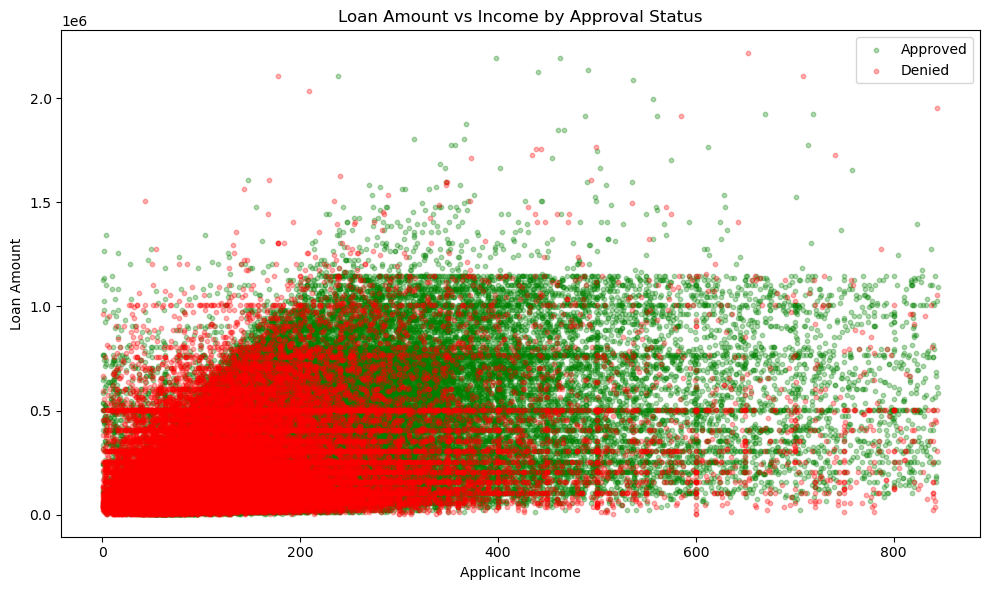

In [300]:
plt.figure(figsize=(10, 6))
approved = hmda_final[hmda_final['action_taken'] == 1]
denied = hmda_final[hmda_final['action_taken'] == 3]

plt.scatter(approved['income'], approved['loan_amount'], 
           alpha=0.3, label='Approved', c='green', s=10)
plt.scatter(denied['income'], denied['loan_amount'], 
           alpha=0.3, label='Denied', c='red', s=10)
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs Income by Approval Status')
plt.legend()
plt.tight_layout()
plt.show()

We can also take a look at some categorical features and how they relate to mortgage acceptance. We can visualize the acceptance rates for each category within a categorical feature (ex. home purchase vs home improvement vs refinancing in loan_purpose)

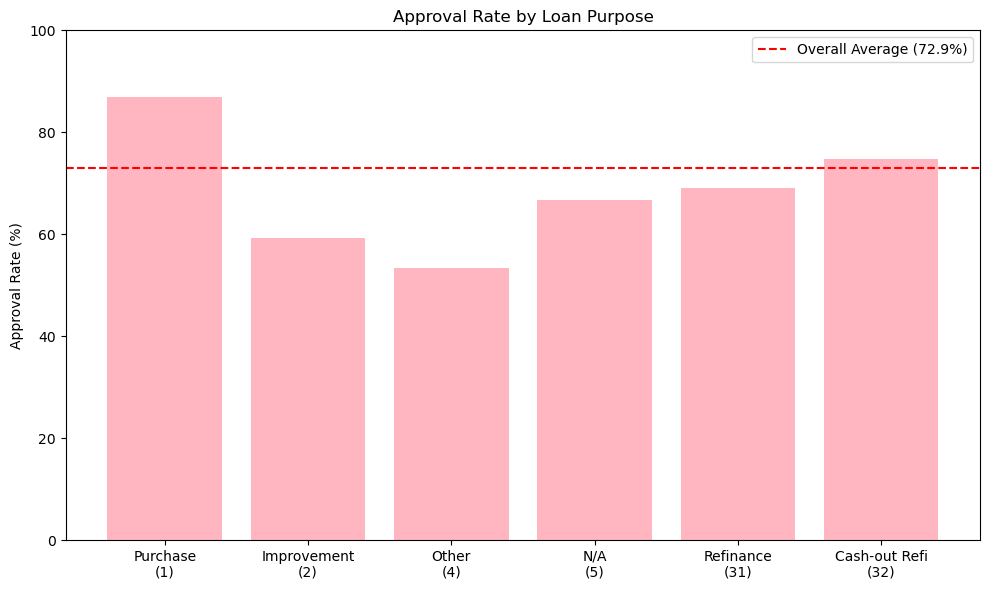


Approval Rates by Loan Purpose:
Purchase: 87.0%
Improvement: 59.2%
Other: 53.5%
N/A: 66.7%
Refinance: 69.1%
Cash-out Refi: 74.8%


In [321]:
# let's start with loan purpose 
# we can calculate the rates of approval by taking the amount of the approved actions over all the actions taken 

approval_by_purpose = hmda_final.groupby('loan_purpose')['action_taken'].apply(
    lambda x: (x == 1).sum() / len(x) * 100
)

plt.figure(figsize=(10, 6))
x_positions = range(len(approval_by_purpose))
plt.bar(x_positions, approval_by_purpose.values, color='lightpink')

# create labels because of weird number labelling
purpose_names = {1: 'Purchase', 2: 'Improvement', 4: 'Other', 
                 5: 'N/A', 31: 'Refinance', 32: 'Cash-out Refi'}
x_labels = [f"{purpose_names.get(idx, idx)}\n({idx})" for idx in approval_by_purpose.index]

plt.xticks(x_positions, x_labels, rotation=0)

plt.ylabel('Approval Rate (%)')
plt.title('Approval Rate by Loan Purpose')
plt.axhline(y=overall_acceptance, color='r', linestyle='--', 
            label=f'Overall Average ({overall_acceptance:.1f}%)')
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Print the values
print("\nApproval Rates by Loan Purpose:")
for purpose, rate in approval_by_purpose.items():
    purpose_names = {1: 'Purchase', 2: 'Improvement', 4: 'Other', 
                     5: 'N/A', 31: 'Refinance', 32: 'Cash-out Refi'}
    print(f"{purpose_names.get(purpose, purpose)}: {rate:.1f}%")

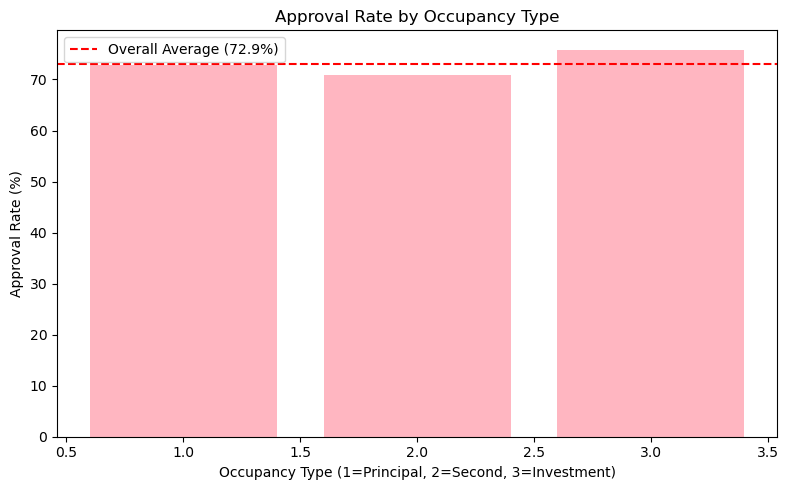

In [327]:
# approval rate by occupancy type
approval_by_occ = hmda_final.groupby('occupancy_type')['action_taken'].apply(
    lambda x: (x == 1).sum() / len(x) * 100
)

plt.figure(figsize=(8, 5))
plt.bar(approval_by_occ.index, approval_by_occ.values, color='lightpink')
plt.xlabel('Occupancy Type (1=Principal, 2=Second, 3=Investment)')
plt.ylabel('Approval Rate (%)')
plt.title('Approval Rate by Occupancy Type')
plt.axhline(y=overall_acceptance, color='r', linestyle='--', label=f'Overall Average ({overall_acceptance:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

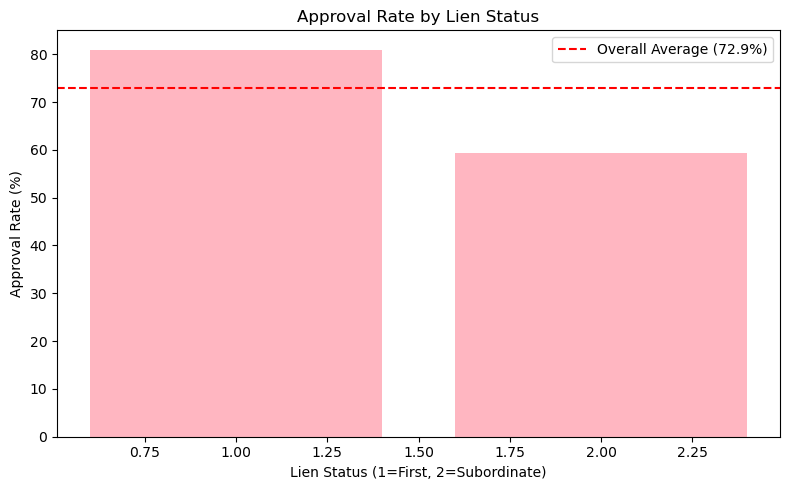

In [329]:
# approval rate by lien status
approval_by_lien = hmda_final.groupby('lien_status')['action_taken'].apply(
    lambda x: (x == 1).sum() / len(x) * 100
)

plt.figure(figsize=(8, 5))
plt.bar(approval_by_lien.index, approval_by_lien.values, color='lightpink')
plt.xlabel('Lien Status (1=First, 2=Subordinate)')
plt.ylabel('Approval Rate (%)')
plt.title('Approval Rate by Lien Status')
plt.axhline(y=overall_acceptance, color='r', linestyle='--', label=f'Overall Average ({overall_acceptance:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

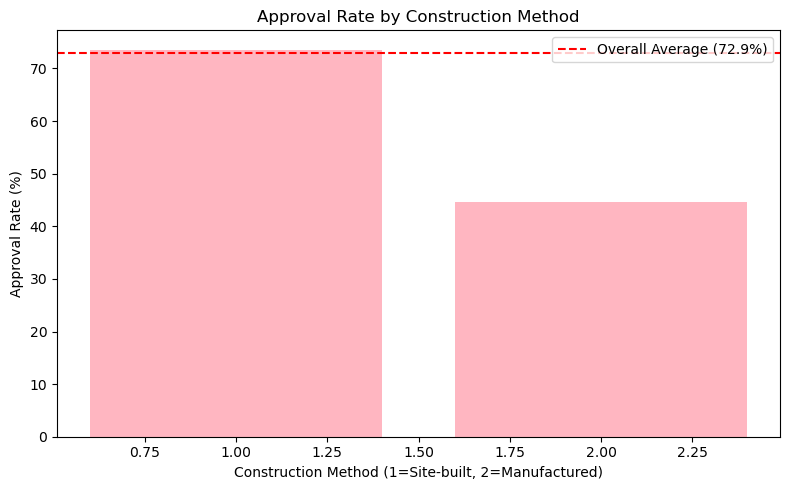

In [335]:
# aproval rate by construction method
approval_by_const = hmda_final.groupby('construction_method')['action_taken'].apply(
        lambda x: (x == 1).sum() / len(x) * 100
    )
    
plt.figure(figsize=(8, 5))
plt.bar(approval_by_const.index, approval_by_const.values, color='lightpink')
plt.xlabel('Construction Method (1=Site-built, 2=Manufactured)')
plt.ylabel('Approval Rate (%)')
plt.title('Approval Rate by Construction Method')
plt.axhline(y=overall_acceptance, color='r', linestyle='--', label=f'Overall Average ({overall_acceptance:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

## Data Preprocessing

In [338]:
# create binary target variable
hmda_final['approved'] = (hmda_final['action_taken'] == 1).astype(int)
print(hmda_final['approved'].value_counts())

approved
1    156840
0     58190
Name: count, dtype: int64


In [344]:
# then, drop this column from the rest of the data
# set y (aka the target variable) to the new column we just created

X = hmda_final.drop(['action_taken', 'approved'], axis=1)
y = hmda_final['approved']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (215030, 17)
Target shape: (215030,)


In [350]:
X.columns

Index(['preapproval', 'loan_purpose', 'lien_status',
       'business_or_commercial_purpose', 'loan_amount', 'construction_method',
       'occupancy_type', 'total_units', 'income', 'debt_to_income_ratio',
       'tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units'],
      dtype='object')

In [354]:
X['tract_owner_occupied_units'].describe()

count    215030.000000
mean       1133.037060
std         532.486019
min           0.000000
25%         730.000000
50%        1114.000000
75%        1511.000000
max        2946.000000
Name: tract_owner_occupied_units, dtype: float64

In [360]:
# for logistic regression, we can one-hot encode the categorical variables 

categorical_features = ['loan_purpose', 'occupancy_type', 
                        'preapproval', 'lien_status', 'business_or_commercial_purpose',
                       'construction_method', 'total_units']

X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

In [362]:
# then, we can create the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training approval rate: {y_train.mean():.2%}")
print(f"Test approval rate: {y_test.mean():.2%}")

Training set size: 172024
Test set size: 43006
Training approval rate: 72.94%
Test approval rate: 72.94%


In [366]:
# we also might want to scale the features for logistic regression so they sit on the same scale
# this only applies to the numerical features
scaler = StandardScaler()

numeric_features = ['loan_amount', 'income', 'debt_to_income_ratio',
       'tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

## Model Training and Evaluation

In [370]:
# initialize LR with class_weight='balanced' to handle imbalanced data
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

lr_model.fit(X_train_scaled, y_train)

# predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# calculate evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

Accuracy: 0.7428
Precision: 0.8778
Recall: 0.7522
ROC-AUC: 0.8148


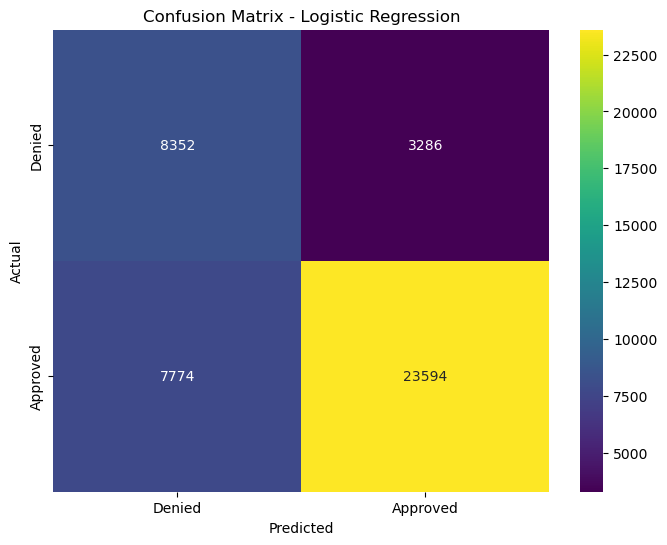

In [374]:
# confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0.5, 1.5], ['Denied', 'Approved'])
plt.yticks([0.5, 1.5], ['Denied', 'Approved'])
plt.show()

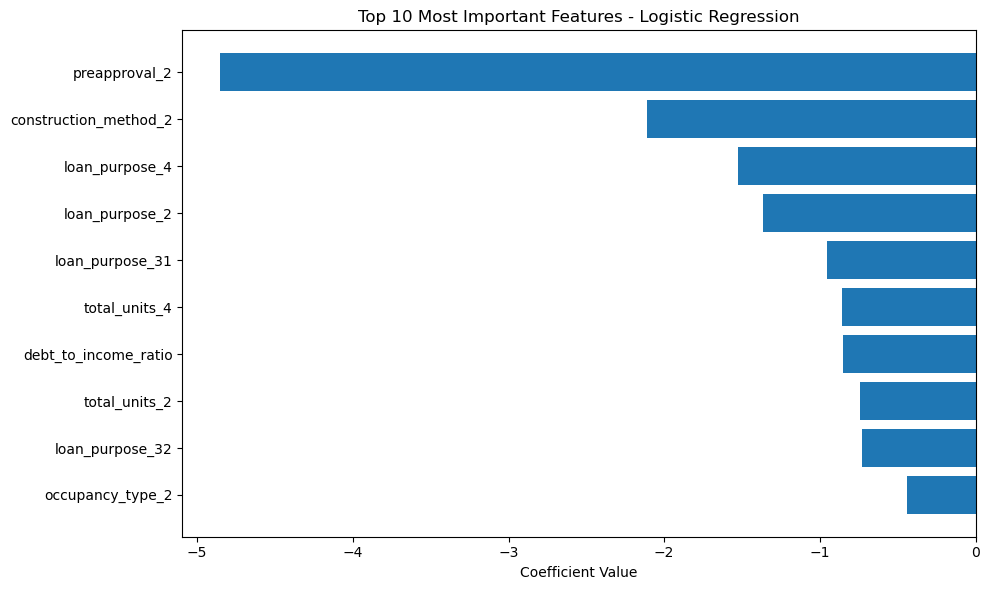


Top 10 Most Important Features:
                  feature  coefficient
17          preapproval_2    -4.851681
20  construction_method_2    -2.113561
11         loan_purpose_4    -1.523647
10         loan_purpose_2    -1.364539
13        loan_purpose_31    -0.952036
27          total_units_4    -0.858978
2    debt_to_income_ratio    -0.853482
21          total_units_2    -0.743330
14        loan_purpose_32    -0.727947
15       occupancy_type_2    -0.438739


In [376]:
# feature importance for logreg
coefficients = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': lr_model.coef_[0]
})
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
coefficients = coefficients.sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
top_10 = coefficients.head(10)
plt.barh(top_10['feature'], top_10['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Most Important Features - Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(coefficients.head(10)[['feature', 'coefficient']])

### Random Forest

In [378]:
# random forest (uses unscaled data)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# calculated metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

Accuracy:  0.8067
Precision: 0.8839
Recall:    0.8461
ROC-AUC:   0.8585


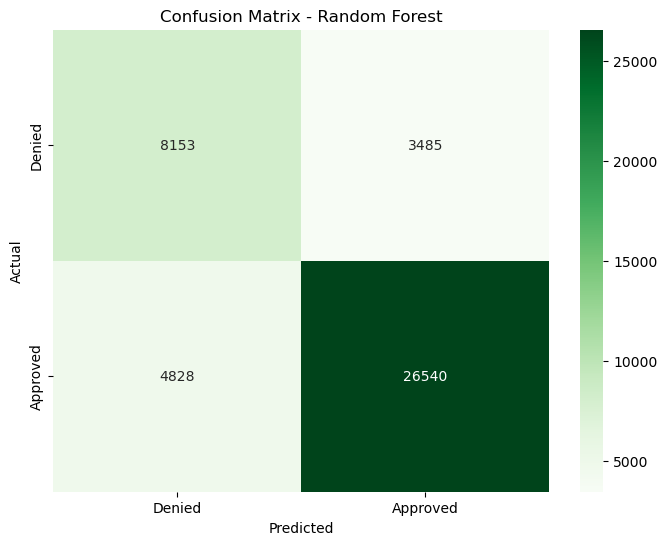

In [380]:
# confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0.5, 1.5], ['Denied', 'Approved'])
plt.yticks([0.5, 1.5], ['Denied', 'Approved'])
plt.show()

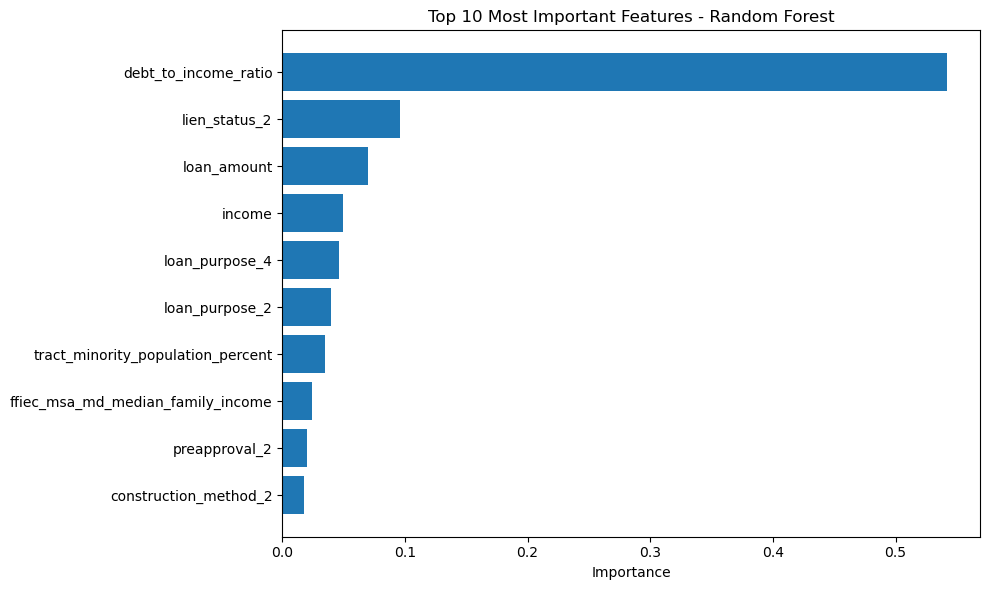


Top 10 Features:
                              feature  importance
2                debt_to_income_ratio    0.541787
18                      lien_status_2    0.095846
0                         loan_amount    0.069967
1                              income    0.049133
11                     loan_purpose_4    0.046408
10                     loan_purpose_2    0.040024
4   tract_minority_population_percent    0.034828
5   ffiec_msa_md_median_family_income    0.024436
17                      preapproval_2    0.020377
20              construction_method_2    0.017946


In [382]:
# feature importance for random forest
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top_10_rf = feature_importance_rf.head(10)
plt.barh(top_10_rf['feature'], top_10_rf['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_importance_rf.head(10))

## Model Comparison

In [395]:
# compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
})

print(results.to_string(index=False))

              Model  Accuracy  Precision   Recall  ROC-AUC
Logistic Regression  0.742827   0.877753 0.752168 0.814791
      Random Forest  0.806701   0.883930 0.846085 0.858459


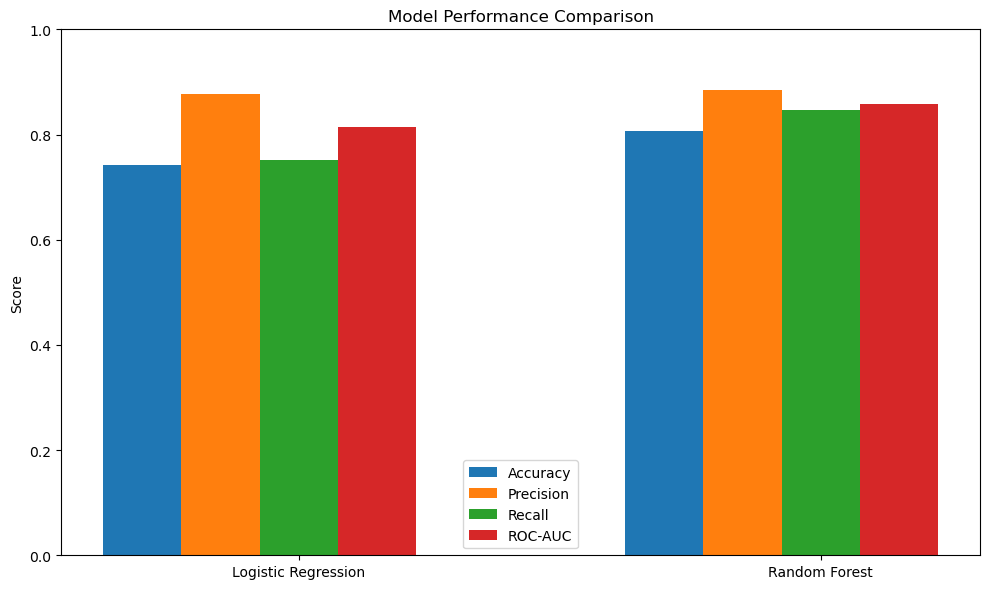

In [399]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.15

bars1 = ax.bar(x - 2*width, results['Accuracy'], width, label='Accuracy')
bars2 = ax.bar(x - width, results['Precision'], width, label='Precision')
bars3 = ax.bar(x, results['Recall'], width, label='Recall')
bars5 = ax.bar(x + 1*width, results['ROC-AUC'], width, label='ROC-AUC')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()